# Word2Vec baseline

Here we train a word2vec model to predict note helpfulness

**Credit:** Notebook was initially written by Michael Wang (@mwang14), and is merely
adapted here

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
from collections import OrderedDict
from tqdm import tqdm
import nltk
import numpy as np
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import gpplot


from core_functions import evaluate_model

In [2]:
train_data = pd.read_csv('../data/processed/training_data.csv')
val_data = pd.read_csv('../data/processed/val_data.csv')
test_data = pd.read_csv('../data/processed/test_data.csv')

### Word2Vec Featurization

We'll load a pre-trained Word2Vec model from gensim. We see that the most similar
words make intuitive sense

In [3]:
corpus = api.load('text8')
wv_model = Word2Vec(corpus, workers=3)

In [4]:
sims = wv_model.wv.most_similar('tree', topn=10)
print(sims)

[('trees', 0.7154202461242676), ('bark', 0.6832413077354431), ('leaf', 0.6762276887893677), ('avl', 0.6166880130767822), ('flower', 0.6028879284858704), ('bird', 0.576224148273468), ('fruit', 0.5726439356803894), ('tiny', 0.5723675489425659), ('leaves', 0.5691754817962646), ('vine', 0.5616295337677002)]


In [5]:
datasets = OrderedDict([('train', {'notes': train_data.iloc[:,:22].drop_duplicates().reset_index(drop=True),
                                   'notes_ratings': train_data}),
                        ('val', {'notes': val_data.iloc[:, :22].drop_duplicates().reset_index(drop=True),
                                 'notes_ratings': val_data}),
                        ('test', {'notes': test_data.iloc[:, :22].drop_duplicates().reset_index(drop=True),
                                  'notes_ratings': test_data})])

In [6]:
def tokenize_text(text):
    tokens = [w.lower() for w in nltk.word_tokenize(text)]
    return tokens

for name, data_dict in tqdm(datasets.items(), total=3):
    notes_df = data_dict['notes']
    notes_ratings_df = data_dict['notes_ratings']
    tokenized_notes = [tokenize_text(text) for text in notes_df['summary']]
    note_arrays = list()
    for tokens in tqdm(tokenized_notes):
        note_vectors = []
        for t in tokens:
            if wv_model.wv.__contains__(t):
                note_vectors.append(wv_model.wv[t])
        if len(note_vectors) > 0:
            avg_note_vector = np.mean(note_vectors, axis=0)
        else:
            avg_note_vector = np.zeros(100)
        note_arrays.append(avg_note_vector)

    X_df = pd.DataFrame(np.array(note_arrays))
    X_df['noteId'] = notes_df['noteId']
    merged_X_df = X_df.merge(notes_ratings_df[['noteId', 'output', 'scaling']],
                             how='inner', on='noteId')
    X = merged_X_df.drop(['noteId', 'output', 'scaling'], axis=1)
    datasets[name]['X'] = X
    datasets[name]['Y'] = merged_X_df['output']
    datasets[name]['scaling'] = merged_X_df['scaling']
    datasets[name]['noteId'] = merged_X_df['noteId']
    print(name, 'size', merged_X_df.shape[0])


 33%|███▎      | 1/3 [00:03<00:07,  3.76s/it]

train size 88185



 67%|██████▋   | 2/3 [00:04<00:01,  1.84s/it]

val size 11641



100%|██████████| 3/3 [00:04<00:00,  1.57s/it]

test size 10507


In [7]:
model = LogisticRegression(random_state=7)
model.fit(datasets['train']['X'], datasets['train']['Y'],
          sample_weight=datasets['train']['scaling'])

LogisticRegression(random_state=7)

In [8]:
for name, data_dict in datasets.items():
    print(name)
    predictions = model.predict(data_dict['X'])
    p_hat = model.predict_proba(data_dict['X'])[:, 1]
    observations = data_dict['Y']
    scaling = data_dict['scaling']
    performance_dict = evaluate_model(predictions, p_hat, observations,
                                      scaling, name)
    data_dict['Y_hat'] = predictions
    data_dict['p_hat'] = p_hat
    data_dict['performance'] = performance_dict

train
val
test


In [9]:
performance_metrics = []
for name, data_dict in datasets.items():
    performance_metrics.append(data_dict['performance'])
performance_metrics_df = pd.DataFrame(performance_metrics)
performance_metrics_df

,accuracy,f1,precision,recall,roc-auc,avg_precision,name
0,0.651872,0.779334,0.657646,0.956281,0.618143,0.723425,train
1,0.641343,0.772036,0.646413,0.958265,0.603067,0.694693,val
2,0.645801,0.776656,0.652348,0.959490,0.618959,0.728550,test


## Feature Importances

In [10]:
wv_vector_df = pd.DataFrame(wv_model.wv.vectors)
wv_vector_df['label'] = np.asarray(wv_model.wv.index_to_key)


### Most positive coefficient

If we look at the highest coefficient in the model, we see words like election,
elections are heavily down-weighted in the model

In [15]:
pos_coef_neg_vals = wv_vector_df.sort_values(model.coef_.argmax()).head(10)[['label', model.coef_.argmax()]]
pos_coef_neg_vals

,label,31
956,highest,-3.778165
3155,ma,-3.684534
1451,exists,-3.673836
2906,hindu,-3.550451
3402,buddhism,-3.395834
2568,da,-3.269072
519,prime,-3.245713
2209,vol,-3.205636
1126,ed,-3.070003
353,college,-3.065385


In [16]:
pos_coef_pos_vals = wv_vector_df.sort_values(model.coef_.argmax()).tail(10)[['label', model.coef_.argmax()]]
pos_coef_pos_vals

,label,31
73,would,4.038765
53,been,4.054894
1098,cost,4.268438
1898,pay,4.541916
1029,engine,4.647632
148,much,4.663092
1563,fuel,4.666774
159,could,5.062294
48,had,5.205876
39,were,5.395151


In [35]:
pos_coef_vals = pd.concat([pos_coef_pos_vals.head(5).sort_values(31, ascending=False),
                           pos_coef_neg_vals.head(5).sort_values(31, ascending=False)])
pos_coef_vals['sign'] = np.sign(pos_coef_vals[31])

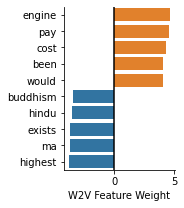

In [38]:
plt.subplots(figsize=(2, 3))
sns.barplot(data=pos_coef_vals, x=31,
            y='label',
            hue='sign', dodge=False)
plt.gca().get_legend().remove()
sns.despine()
plt.axvline(x=0, color='black')
plt.ylabel('')
plt.xlabel('W2V Feature Weight')
gpplot.savefig('../figures/w2v_pos_vec.png', dpi=300)


### Most negative coefficient

We see 'www' in with a strong negative weight for the most negative feature, suggesting
the model is learning that links are typically helpful in notes.

In [39]:
neg_coef_neg_vals = wv_vector_df.sort_values(model.coef_.argmin()).head(10)[['label', model.coef_.argmin()]]
neg_coef_neg_vals

,label,78
113,government,-5.276271
354,republic,-5.112436
455,minister,-5.098285
1505,secretary,-4.927094
186,king,-4.776280
752,object,-4.568161
93,state,-4.491601
1094,governor,-4.414857
153,what,-4.390400
212,god,-4.339799


In [40]:
neg_coef_pos_val = wv_vector_df.sort_values(model.coef_.argmin()).tail(10)[['label', model.coef_.argmin()]]
neg_coef_pos_val

,label,78
834,refer,3.175287
679,births,3.276959
486,middle,3.295425
31,be,3.423988
1597,rd,3.447224
211,include,3.596114
555,est,3.639720
90,th,3.676686
257,age,4.189123
2117,bwv,4.216451


In [43]:

neg_coef_vals = pd.concat([neg_coef_pos_val.head(5).sort_values(78, ascending=False),
                           neg_coef_neg_vals.head(5).sort_values(78, ascending=False)])
neg_coef_vals['sign'] = np.sign(neg_coef_vals[78])

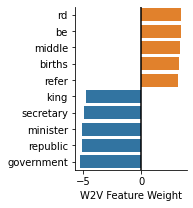

In [45]:
plt.subplots(figsize=(2, 3))
sns.barplot(data=neg_coef_vals, x=78,
            y='label',
            hue='sign', dodge=False)
plt.gca().get_legend().remove()
sns.despine()
plt.axvline(x=0, color='black')
plt.ylabel('')
plt.xlabel('W2V Feature Weight')
gpplot.savefig('../figures/w2v_neg_vec.png', dpi=300)